### Supervised KNN Regression

In [6]:
import os
import time
import pandas as pd
import numpy as np
import scipy.optimize as spo
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Ensemble
from sklearn.ensemble import BaggingRegressor

from util_SR import *

#### Core of the method
A way to normalize the input features/variables is the Min-Max scaler. By doing so, all features will be transformed into the range [0,1] meaning that the minimum and maximum value of a feature/variable is going to be 0 and 1, respectively.
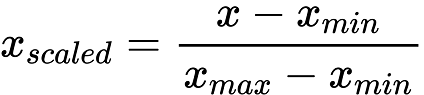
#### Why to normalize prior to model fitting?
The main idea behind normalization/standardization is always the same. Variables that are measured at different scales do not contribute equally to the model fitting & model learned function and might end up creating a bias. Thus, to deal with this potential problem feature-wise normalization such as MinMax Scaling is usually used prior to model fitting.

In [7]:
def train_knn(knn, X, y):
    print ("Training {}...".format(knn.__class__.__name__))
    start = time.time()
    
    # parameters for gridsearchCV
    k = [1,5,10,15,20,25,30]
    leaves = [1,5,10,15,20,25,30]
    weights = ['uniform', 'distance']
    parameters = {'n_neighbors': k, 'leaf_size': leaves, 'weights': weights}
    
    # Implement GridSearchCV
    knn = GridSearchCV(knn, parameters, cv=10)
    knn.fit(X, y)
    
    print ("best parameter: ", knn.best_params_)
    print ("best score: ", knn.best_score_)
    print ("\n")
    
    end = time.time()
    return knn

In [8]:
def parametricKnnRegression(symbol):
    """
    build a k nearest neighbour regression model using sklearn.neighbors
    :param X: Feature dataset
    :param y: label dataset
    :return: a knn regression model
    """
    df = pd.read_csv(symbol_to_path(symbol), index_col='Date', 
                parse_dates=True, 
                usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'], 
                na_values=['nan'])
    
    # add new column to view Adj Close 5 days later
    df['Adj_Close_5_Days_Later'] = df['Adj Close']
    df['Adj_Close_5_Days_Later'] = df['Adj_Close_5_Days_Later'].shift(-5)
    
    df= df.dropna()
    df = normalised_MinMaxScaler(df)
    plot_data(df)
    
    # Get the features and labels from the stock dataset
    X = df.iloc[:,:-1]
    y = df.iloc[:, -1]
    # Split the data into training/testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    ##Not sure to use gridsearchCV.train_test_split because it doesn't do roll-forward cross validation. 
    
    # Apply knn regression algorithm
    knn = KNeighborsRegressor()
    train_knn(knn, X_train, y_train)
    
    # Create knn regression object
    regr = KNeighborsRegressor()
    #regr = KNeighborsRegressor(n_neighbors=15, weights='distance', leaf_size=1)
    
    # Fit the model using the training sets
    regr.fit(X_train, y_train)
    
    # Query
    y_predict = regr.predict(X_test)
    
    # Plot outputs
    print ("\n")
    plt.figure(figsize=(12,10))
    plt.title("Real-world results vs machine learning predictions")
    plt.xlabel("Prediction")
    plt.ylabel("Real-world result")
    plt.scatter(y_predict, y_test, color='blue')
    plt.show()
    
    # Score
    print ("Score on training data")
    print ("regr.score(X_train, y_train): ", regr.score(X_train, y_train))
   
    print ("Score on testing (unseen) data")
    print('regr.score(X_test, y_test): %.2f' % regr.score(X_test, y_test))
    # The mean square error
    print ("Mean squared error: ", mean_squared_error(y_test, y_predict))
   
    knnreg_bagging = BaggingRegressor(KNeighborsRegressor(), max_samples=0.5, max_features=0.5)
    #linreg_bagging = BaggingRegressor(linear_model.LinearRegression(), max_samples=1.0, max_features=1.0)
    
    # Fit model to training data
    knnreg_bagging.fit(X_train, y_train)
    
    # Plot outputs
    plt.figure(figsize=(12,10))
    plt.title("Actual results vs machine learning predictions")
    plt.xlabel("Prediction")
    plt.ylabel("Actual result")
    plt.scatter(knnreg_bagging.predict(X_test), y_test, color='blue')
    plt.show()
    
    # Explained variance score: 1 is perfect
    # Score
    print ("Score - variance between prediction and actual results")
    print('linreg_bagging.score(X_test, y_test): %.2f' % knnreg_bagging.score(X_test, y_test))
    
    # The mean square error
    print ("Mean squared error: ", mean_squared_error(knnreg_bagging.predict(X_test), y_test), "\n")


In [9]:
def test_run():
    parametricKnnRegression('SPY')

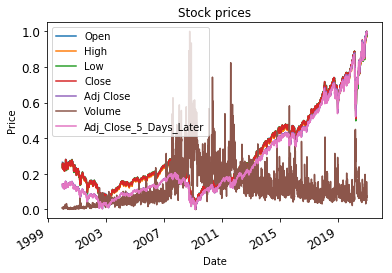

Training KNeighborsRegressor...
best parameter:  {'leaf_size': 1, 'n_neighbors': 15, 'weights': 'distance'}
best score:  0.997111509593






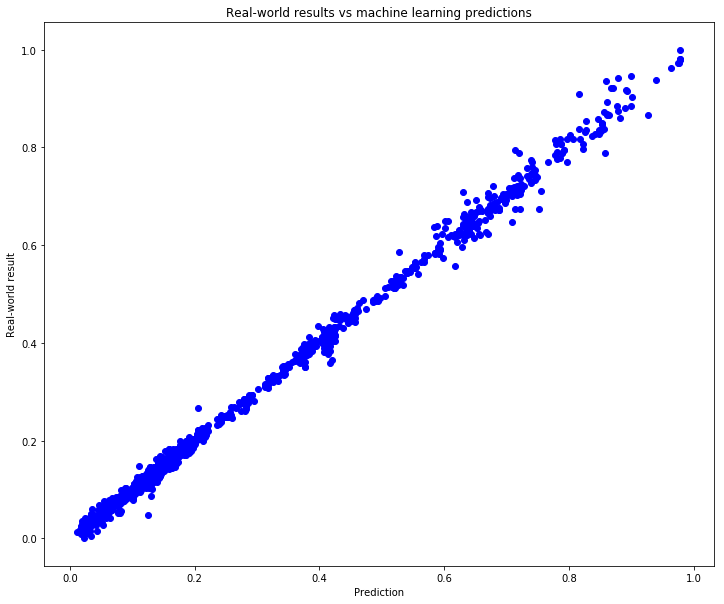

Score on training data
regr.score(X_train, y_train):  0.99805085107
Score on testing (unseen) data
regr.score(X_test, y_test): 1.00
Mean squared error:  0.000159780378048


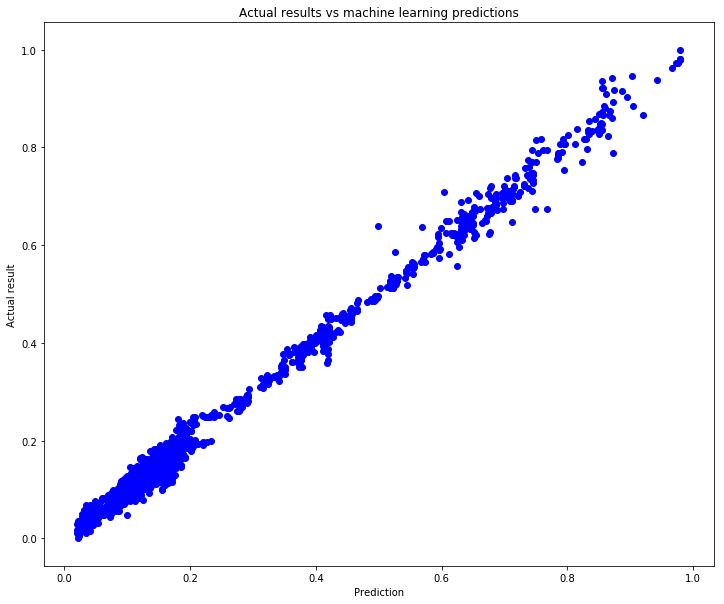

Score - variance between prediction and actual results
linreg_bagging.score(X_test, y_test): 0.99
Mean squared error:  0.000352615008086 



In [10]:
if __name__ == "__main__":
    test_run()